# Time-resolved fitting with RL

Run 189245: 0.6V to 0.1V

In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

In [114]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189246-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189245-time-resolved.json')
#ec_cp1 = np.loadtxt(os.path.join(project_dir, 'ec-data', 'Expt6_Summary_CP1.txt'), delimiter=',', skiprows=1).T


with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = False
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()


Number of times: 25
0


## View the initial time and check that the initial model makes sense

reward: -4.135434933957153
[-0.27628032  0.30918931  0.46417551]


<IPython.core.display.Javascript object>


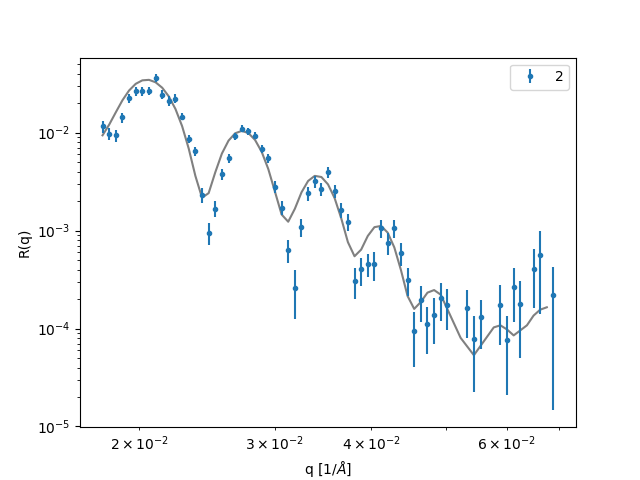

In [104]:
# choose a random action or use our initial fit
if False:
    action = env.action_space.sample() 
else:
    action = env.normalized_parameters

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
# show the current position and reward
env.render(action=action, reward=reward) 
env.plot(errors=True)

## Train or load model

In [105]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    #save_path="./logs-forward-no-final-state/",
    save_path="./logs-test/",
    name_prefix="rl_model-forward",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if False:
    model.learn(2000)
    #model.learn(200000, callback=checkpoint_callback)
    #model.save('UIUC-06-to-01-SAC-forward-no-final-state')
else:
    model = SAC.load('UIUC-06-to-01-SAC-forward-no-final-state')

CPU times: user 27.2 ms, sys: 20.4 ms, total: 47.6 ms
Wall time: 43.4 ms


# Compute uncertainties

In [113]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(3, 25, 100)
(3, 25)


## Run the agent on the time series data

In [107]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    chi2.append(env.chi2)
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (timestamps[i], obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)

Number of times: 25
Time 0 [0.]: -3.19848 [False] -3.19848
Time 60 [0.04166667]: -3.25606 [False] -6.45454
Time 120 [0.08333334]: -3.05237 [False] -9.5069
Time 180 [0.125]: -2.58836 [False] -12.0953
Time 240 [0.16666667]: -2.174 [False] -14.2693
Time 300 [0.20833333]: -3.20168 [False] -17.4709
Time 360 [0.25]: -3.10147 [False] -20.5724
Time 420 [0.29166666]: -1.9259 [False] -22.4983
Time 480 [0.33333334]: -2.11349 [False] -24.6118
Time 540 [0.375]: -2.15923 [False] -26.771
Time 600 [0.41666666]: -1.86792 [False] -28.6389
Time 660 [0.45833334]: -2.22696 [False] -30.8659
Time 720 [0.5]: -2.5659 [False] -33.4318
Time 780 [0.5416667]: -2.74258 [False] -36.1744
Time 840 [0.5833333]: -2.28227 [False] -38.4567
Time 900 [0.625]: -2.73018 [False] -41.1868
Time 960 [0.6666667]: -2.75502 [False] -43.9419
Time 1020 [0.7083333]: -2.61435 [False] -46.5562
Time 1080 [0.75]: -3.58081 [False] -50.137
Time 1140 [0.7916667]: -2.82667 [False] -52.9637
Time 1200 [0.8333333]: -2.73044 [False] -55.6941
Time 

## Plot the results and compare to the Bayesian approach

<IPython.core.display.Javascript object>


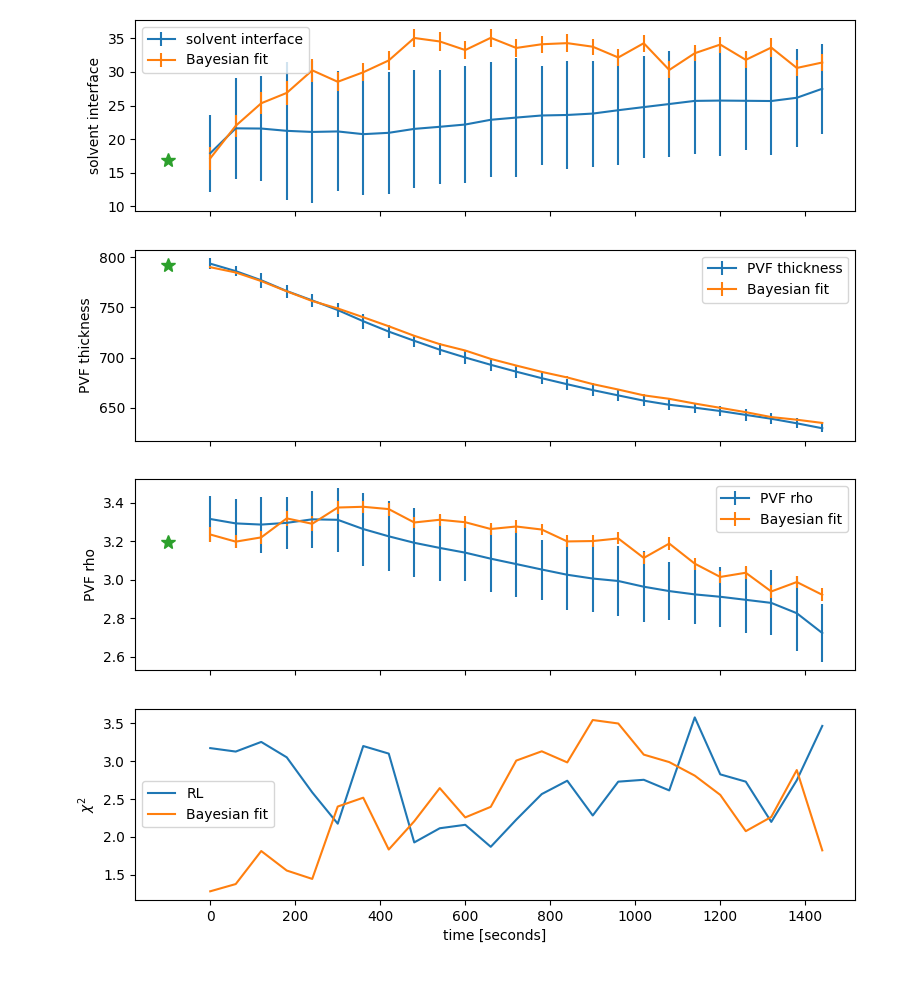

['solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'time [seconds]')

In [110]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189245-bayes-forward.json')) as fd:
    bayes_fits = json.load(fd)

t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit')
    
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
plt.plot(_times, bayes_fits['chi2'], label = 'Bayesian fit')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

## Nicer plot

<IPython.core.display.Javascript object>


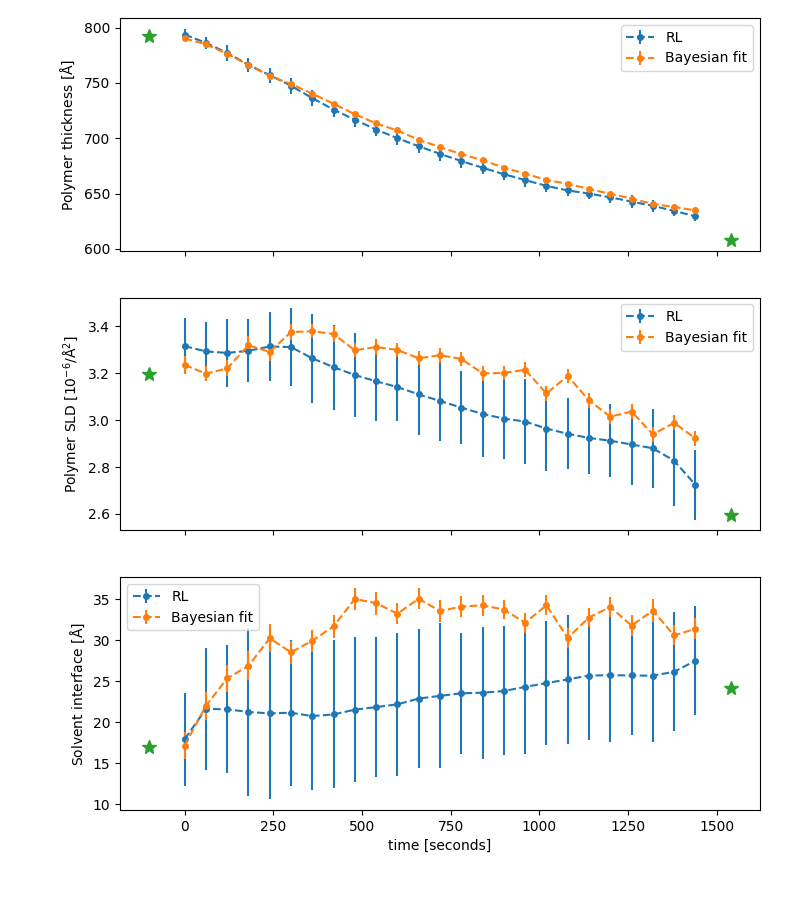

['solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'time [seconds]')

In [111]:

fig, axs = plt.subplots(3,1, dpi=100, figsize=(8,9), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)

axes = ['Solvent interface [$\mathrm{\AA}$]',
        'Polymer thickness [$\mathrm{\AA}$]',
        'Polymer SLD [$10^{-6}/\mathrm{\AA}^2$]']

position = 0
for i in [1,2,0]:
    position += 1
    ax = plt.subplot(3, 1, position)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label='RL', marker='.', markersize=8, linestyle='--')

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit', marker='.', markersize=8, linestyle='--')
    
    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(axes[i])
    plt.legend()

plt.xlabel("time [seconds]")

Number of times: 25


<IPython.core.display.Javascript object>


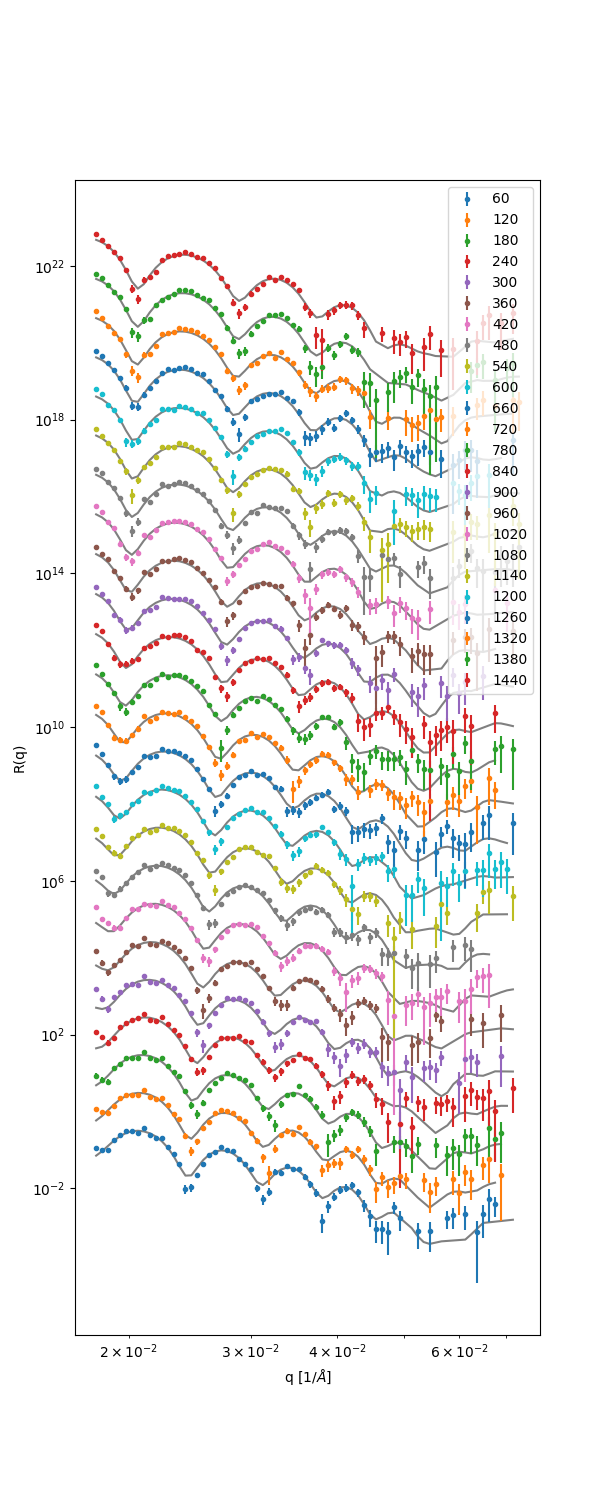

In [86]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=_times[i])


# Training progression

<IPython.core.display.Javascript object>


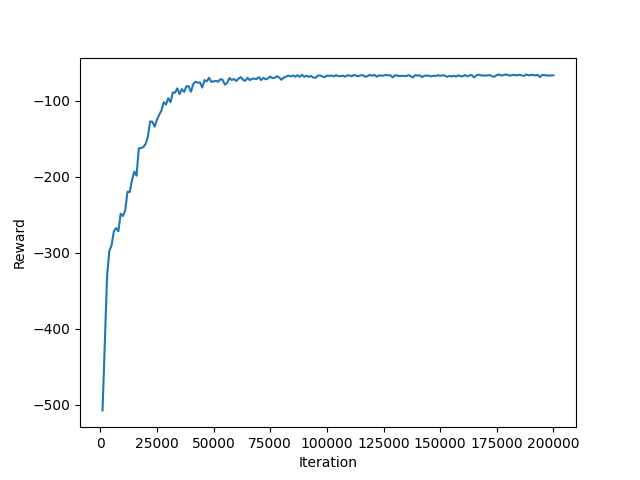

In [11]:
log_dir = "./logs-forward-no-final-state/"
_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
    return episode_reward

itr_list = []
reward_list = []

for file in _dir_list:
    model = SAC.load(os.path.join(log_dir, file))
    reward = evaluate(model)
    iteration = int(file.replace("rl_model-forward_", "").replace("_steps.zip", ""))
    itr_list.append(iteration)
    reward_list.append(reward)

itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()
        

## Produce text to latex table

In [101]:
print(env.par_labels)
print()

# Add chi2

table_str = "Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) &  Interface ($\mathrm{\AA}$) & $\chi^2$ & "
table_str += "Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) & Interface ($\mathrm{\AA}$) & $\chi^2$ \\\\ \n\n"

# RL approach
sld_values = pars[2]
sld_err = errs[2]

thick_values = pars[1]
thick_err = errs[1]

rough_values = pars[0]
rough_err = errs[0]

# Bayesian approach
sld_values_b = bayes_fits['pvf_rho']
sld_err_b = bayes_fits['pvf_rho_err']

thick_values_b = bayes_fits['pvf_thickness']
thick_err_b = bayes_fits['pvf_thickness_err']

rough_values_b = bayes_fits['solvent_interface']
rough_err_b = bayes_fits['solvent_interface_err']


for i in range(pars.shape[1]):  
    table_str += "$%3.0f \pm %3.0f$ & $%3.1f \pm %3.1f$ & $%3.0f \pm %3.0f$ & %1.1f & " % (
        thick_values[i], thick_err[i],
        sld_values[i], sld_err[i],
        rough_values[i], rough_err[i], chi2[i]
    )
    table_str += "$%3.0f \pm %3.0f$ & $%3.2f \pm %3.2f$ & $%3.0f \pm %3.0f$ & %1.1f \\\\ \n" % (
        thick_values_b[i], thick_err_b[i],
        sld_values_b[i], sld_err_b[i],
        rough_values_b[i], rough_err_b[i], bayes_fits['chi2'][i]
    )

print(table_str)
  
    


['solvent interface', 'PVF thickness', 'PVF rho']

Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) &  Interface ($\mathrm{\AA}$) & $\chi^2$ & Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) & Interface ($\mathrm{\AA}$) & $\chi^2$ \\ 

$794 \pm   5$ & $3.3 \pm 0.1$ & $ 18 \pm   5$ & 5.7 & $790 \pm   1$ & $3.24 \pm 0.04$ & $ 17 \pm   2$ & 1.3 \\ 
$786 \pm   5$ & $3.3 \pm 0.1$ & $ 22 \pm   8$ & 3.1 & $785 \pm   1$ & $3.20 \pm 0.03$ & $ 22 \pm   2$ & 1.4 \\ 
$777 \pm   6$ & $3.3 \pm 0.2$ & $ 22 \pm   9$ & 3.3 & $776 \pm   1$ & $3.22 \pm 0.03$ & $ 25 \pm   2$ & 1.8 \\ 
$766 \pm   6$ & $3.3 \pm 0.2$ & $ 21 \pm   9$ & 3.1 & $766 \pm   1$ & $3.32 \pm 0.04$ & $ 27 \pm   2$ & 1.6 \\ 
$757 \pm   7$ & $3.3 \pm 0.2$ & $ 21 \pm   8$ & 2.6 & $756 \pm   1$ & $3.29 \pm 0.04$ & $ 30 \pm   2$ & 1.4 \\ 
$747 \pm   7$ & $3.3 \pm 0.2$ & $ 21 \pm   9$ & 2.2 & $749 \pm   1$ & $3.38 \pm 0.03$ & $ 29 \pm   1$ & 2.4 \\ 
$736 \pm   6$ & $3.3 \pm 0.2$ & $ 21 \pm   8$ & 3.2 & $740 \pm   1$ &